<a href="https://colab.research.google.com/github/martin-xxj/EMiSE/blob/master/EMiSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Вступ до ЕМПІ


## Частина 1


###Ініціалізація, підготовка датасету


In [0]:
import pandas as pd

#мій steamID
steam_ID32 = '104604745'
# steam_ID32 = '112963684'

#створюємо Dataframe історії матчів

matches_url = "https://api.opendota.com/api/players/" + steam_ID32 + "/matches"

heroes_url = "https://api.opendota.com/api/heroes"

#альтернативні посилання, сервер інколи просто лежить
#matches_url = "https://jsonblob.com/api/jsonBlob/f2f9d37c-cbc3-11e8-ae04-5de0ea21e93d" 
#heroes_url = "https://jsonblob.com/api/jsonBlob/8df561b5-cbc3-11e8-ae04-01b4edcc50c4"

matches = pd.read_json(matches_url, orient='records')
heroes = pd.read_json(heroes_url)
#join'имо створені Dataframe'и 
matches = matches.set_index('hero_id').join(heroes.set_index('id')).sort_values(by='match_id')
matches.reset_index(inplace = True)

matches.head()

,index,assists,deaths,duration,game_mode,kills,leaver_status,lobby_type,match_id,party_size,...,radiant_win,skill,start_time,version,attack_type,legs,localized_name,name,primary_attr,roles
0,83,0,1,372,4,0,1,0,333991287,NaN,...,False,NaN,2013-10-05 12:14:41,NaN,Melee,2.0,Treant Protector,npc_dota_hero_treant,str,"[Support, Initiator, Durable, Disabler, Escape]"
1,86,0,13,2315,1,1,2,0,334011324,NaN,...,False,NaN,2013-10-05 12:30:01,NaN,Ranged,2.0,Rubick,npc_dota_hero_rubick,int,"[Support, Disabler, Nuker]"
2,20,0,0,1082,1,1,1,0,401678802,NaN,...,False,NaN,2013-11-27 16:22:40,NaN,Ranged,2.0,Vengeful Spirit,npc_dota_hero_vengefulspirit,agi,"[Support, Initiator, Disabler, Nuker, Escape]"
3,40,4,6,2062,1,0,1,0,401833965,NaN,...,False,NaN,2013-11-27 18:50:08,NaN,Ranged,0.0,Venomancer,npc_dota_hero_venomancer,agi,"[Support, Nuker, Initiator, Pusher, Disabler]"
4,5,22,7,2595,1,20,0,0,402632792,NaN,...,False,NaN,2013-11-28 14:24:30,NaN,Ranged,2.0,Crystal Maiden,npc_dota_hero_crystal_maiden,int,"[Support, Disabler, Nuker, Jungler]"


In [0]:
#Додаємо, модифікуємо, редагуємо деякі колонки
#додаємо деякі колонки
matches['KDA'] = matches.apply(lambda row: (row.kills + row.assists)/(row.deaths if row.deaths>0 else 1) , axis=1)
matches['faction'] = matches.apply(lambda row: 'radiant' if row.player_slot<128 else 'dire', axis=1)
matches['win'] = matches.apply(lambda row: True if row.faction == 'radiant' and row.radiant_win == True or row.faction == 'dire' and row.radiant_win == False  else False, axis=1)
matches['duration_sec'] = matches['duration']

#перетворюємо duration в зручний для людини вигляд
import datetime, math
matches['duration'] = matches['duration'].map(lambda row: datetime.timedelta(seconds=row))
#замінюємо NaN на 0, оскільки це має сенс
matches['party_size'] = matches['party_size'].map(lambda row : int(row if not math.isnan(row) else 0))
matches = matches.rename(index=str, columns={"localized_name": "hero_name"})

matches = matches.drop(columns=['leaver_status', 'version','name', 'lobby_type','game_mode','skill','index','player_slot', 'radiant_win'])

#фінальний вигляд
matches.head()

,assists,deaths,duration,kills,match_id,party_size,start_time,attack_type,legs,hero_name,primary_attr,roles,KDA,faction,win,duration_sec
0,0,1,00:06:12,0,333991287,0,2013-10-05 12:14:41,Melee,2.0,Treant Protector,str,"[Support, Initiator, Durable, Disabler, Escape]",0.000000,dire,True,372
1,0,13,00:38:35,1,334011324,0,2013-10-05 12:30:01,Ranged,2.0,Rubick,int,"[Support, Disabler, Nuker]",0.076923,radiant,False,2315
2,0,0,00:18:02,1,401678802,0,2013-11-27 16:22:40,Ranged,2.0,Vengeful Spirit,agi,"[Support, Initiator, Disabler, Nuker, Escape]",1.000000,radiant,False,1082
3,4,6,00:34:22,0,401833965,0,2013-11-27 18:50:08,Ranged,0.0,Venomancer,agi,"[Support, Nuker, Initiator, Pusher, Disabler]",0.666667,radiant,False,2062
4,22,7,00:43:15,20,402632792,0,2013-11-28 14:24:30,Ranged,2.0,Crystal Maiden,int,"[Support, Disabler, Nuker, Jungler]",6.000000,dire,True,2595


### Емпіричні дослідження даних


In [0]:
matches['KDA'].describe()

count    4865.000000
mean        4.651673
std         5.288704
min         0.000000
25%         1.625000
50%         3.000000
75%         5.400000
max        40.000000
Name: KDA, dtype: float64

In [0]:
matches['duration'].describe()

count                      4726
mean     0 days 00:40:17.049513
std      0 days 00:11:23.900909
min             0 days 00:06:12
25%             0 days 00:32:33
50%             0 days 00:39:21
75%             0 days 00:47:05
max             0 days 01:39:09
Name: duration, dtype: object

In [0]:
matches.describe()

,assists,deaths,duration,kills,match_id,party_size,legs,KDA,duration_sec
count,4726.000000,4726.000000,4726,4726.000000,4.726000e+03,4726.000000,4725.000000,4726.000000,4726.000000
mean,12.491748,6.666314,0 days 00:40:17.049513,6.927000,2.034895e+09,0.085908,2.114709,4.668464,2417.049513
std,7.189133,3.884436,0 days 00:11:23.900909,5.131165,1.151879e+09,0.348275,1.119248,5.307983,683.900910
min,0.000000,0.000000,0 days 00:06:12,0.000000,3.339913e+08,0.000000,0.000000,0.000000,372.000000
25%,7.000000,4.000000,0 days 00:32:33,3.000000,8.963465e+08,0.000000,2.000000,1.615385,1953.000000
50%,12.000000,6.000000,0 days 00:39:21,6.000000,1.998201e+09,0.000000,2.000000,3.000000,2361.000000
75%,17.000000,9.000000,0 days 00:47:05,10.000000,2.985230e+09,0.000000,2.000000,5.500000,2825.000000
max,52.000000,36.000000,0 days 01:39:09,34.000000,4.086111e+09,3.000000,8.000000,40.000000,5949.000000


In [0]:
matches['kills'].mode()

0    3
dtype: int64

In [0]:
matches['deaths'].median()

6.0

In [0]:
matches['duration'].mean()

Timedelta('0 days 00:40:17.049513')

In [0]:
from scipy.stats.mstats import gmean

gmean(matches['duration_sec'], axis=0)

2317.307964273644

In [0]:
from scipy.stats.mstats import hmean

hmean(matches['duration_sec'], axis=0)

2205.5037709129087

In [0]:
import numpy as np
matches['KDA'].quantile(np.linspace(0, 1, 11, True))
matches.quantile([0, .25, .5, .75, .9, 1])


,assists,deaths,kills,match_id,party_size,legs,KDA,win,duration_sec
0.00,0.0,0.0,0.0,3.339913e+08,0.0,0.0,0.000000,0.0,372.0
0.25,7.0,4.0,3.0,8.963465e+08,0.0,2.0,1.615385,0.0,1953.0
0.50,12.0,6.0,6.0,1.998201e+09,0.0,2.0,3.000000,1.0,2361.0
0.75,17.0,9.0,10.0,2.985230e+09,0.0,2.0,5.500000,1.0,2825.0
0.90,22.0,12.0,14.0,3.719594e+09,0.0,4.0,10.000000,1.0,3325.0
1.00,52.0,36.0,34.0,4.086111e+09,3.0,8.0,40.000000,1.0,5949.0


###Контрольні питання

 <pre>
 **1.  Які основні емпіричні методи ви знаєте? Коротко опишіть їх суть.**
    1) **Спостереження** — цілеспрямоване сприйняття явищ.
        *дає можливість зібрати емпіричні факти та гіпотези.*
    2) **Опис** — Фіксація засобами мови відомостей про об'єкти.
        *дає можливість зібрати емпіричні факти та гіпотези.*
    3) **Вимірювання** — порівняння об'єктів по яких-небудь загальних властивостях.
    4) **Експеримент** — спостереження в спеціально створених контрольованих умовах.
    5) **Порівняння** — одночасне співвідносне дослідження і оцінка загальних для об'єктів властивостей та ознак.

**2. Яка основна задача застосування емпіричних методів?**
    Підтвердити або спростувати гіпотези на основі аналізу статистичних показників.

**3. Що таке статистичний показник? Яка його суть?**
    Ознака наявності або відсутності досліджуваної концепції.

    Наприклад, якщо змінною є релігійність, а одиницею аналізу є особистість, то одним із потенційно більш численних показників релігійності цього індивідууму буде те, чи вони відвідують релігійні служби; інші — як часто, чи вони жертвують гроші релігійним організаціям.

**4. Опишіть суть закону великих чисел.**
    Завжди знайдеться така кількість випробувань, при якій з будь-якою заданою наперед імовірністю частота появи деякої події буде як завгодно мало відрізнятися від її імовірності.
    
**5. В чому полягає ключова небезпека при нерозумінні до якої області відноситься величина: "Крайнестану" чи "Среднестану"?**
    Величина "Крайнестану" може суттєво змінити вихідні дані, в той час як величина "Среднестану" майже їх не змінює.
    
**6. Опишіть процес первинної обробки даних. Первинна обробка даних включає в себе:**
- табуляцію
- впорядкування у варіаційні послідовності (або ряди)
- групування (при побудові інтервального варіаційного ряду)
- побудову статистичного розподілу
- обчислення окремих статистичних параметрів

**7. Що таке табуляція? Які види табуляції ви знаєте? За яких умов варто застосовувати кожен з них?**
    1) **Табулювання** — підготовка даних, підрахунок кількості подій, які попадають в різні категорії.
    2) **Проста табуляція** — підрахунок кількості подій, які попадають в кожну категорію, коли категорії базуються на одній змінній.
    3) **Перехресна табуляція** — підрахунок кількості подій, які попадають в кожну з декількох категорій, коли категорії базуються на двох і більш змінних, що розглядаються одночасно.
    
**8. Що таке експеримент?**
    Проведення у визначених умовах серії дослідів для спостереження за станом об'єкта дослідження, які дозволяють стежити за його змінами і відтворювати їх кожний раз під час повторення дослідів.



##Частина 2

###Вибірка


####Проста випадкова вибірка (ПВВ) (simple random sample)


In [0]:
def compare_mean(sample):
  print('mean of statistical population\n', matches.mean(), '\n\n', 'mean of given sample\n', sample.mean())
  
random_sample = matches.sample(len(matches.index)//3)
compare_mean(random_sample)

mean of statistical population
 assists                        12.4917
deaths                         6.66631
duration        0 days 00:40:17.049513
kills                            6.927
match_id                    2.0349e+09
party_size                   0.0859077
legs                           2.11471
KDA                            4.66846
win                            0.53449
duration_sec                   2417.05
dtype: object 

 mean of given sample
 assists                        12.2102
deaths                         6.69968
duration        0 days 00:39:47.863492
kills                          6.74159
match_id                   2.03621e+09
party_size                   0.0895238
legs                           2.07619
KDA                             4.5288
win                           0.526349
duration_sec                   2387.86
dtype: object


####Стратифікована вибірка (stratified sample)


In [0]:

strats = [pd.DataFrame()]*3

strats[0] = matches[matches.KDA < 2]
strats[1] = matches[(matches.KDA >= 2) &
                    (matches.KDA <= 5)]
strats[2] = matches[matches.KDA > 5]

for i,strat in enumerate(strats):
  strats[i] = strats[i].sample(int(len(strats[i].index)*0.33))
strat_sample = pd.concat(strats)

compare_mean(strat_sample)



mean of statistical population
 assists                        12.4917
deaths                         6.66631
duration        0 days 00:40:17.049513
kills                            6.927
match_id                    2.0349e+09
party_size                   0.0859077
legs                           2.11471
KDA                            4.66846
win                            0.53449
duration_sec                   2417.05
dtype: object 

 mean of given sample
 assists                         12.154
deaths                         6.57381
duration        0 days 00:39:44.112965
kills                           6.9923
match_id                   2.00198e+09
party_size                    0.071887
legs                           2.08344
KDA                            4.60855
win                           0.537869
duration_sec                   2384.11
dtype: object


#### Групова вибірка (cluster sample)

In [0]:
import random

cluster_count = 10
clusters = [pd.DataFrame()]*cluster_count

#використовуємо створені у минулому прикладі страти
for i in range (0,3):                         #проходимось по кожній страті
  for index, row in strats[i].iterrows():                # по кожному рядку страти
    ind = random.randint(0,cluster_count-1)   #рандомимо індекс кластера
    clusters[ind] = clusters[ind].append(row) #додаємо рядок кластера
    
for i in range(0,len(clusters)):              #можемо переконатись, що кластери більш-менш подібні
  print(i , ' cluster - ', len(clusters[i].index), ' elements')
  print(clusters[i].mean())  
    
clusters = random.sample(clusters,len(clusters)//3) #робимо випадкову вибірку з усіх кластерів

for i,cluster in enumerate(clusters):
  clusters[i] = clusters[i].sample(int(len(clusters[i].index)*0.33)) # і таку ж вибірку для кожного кластера
cluster_sample = pd.concat(clusters)          #склеюємо все докупи

compare_mean(cluster_sample)

0  cluster -  153  elements
KDA                            4.23848
assists                        11.5686
deaths                         6.46405
duration        0 days 00:40:06.895424
duration_sec                    2406.9
kills                          7.29412
legs                           2.15686
match_id                   1.88901e+09
party_size                   0.0653595
win                           0.509804
dtype: object
1  cluster -  164  elements
KDA                            4.31669
assists                        11.7988
deaths                         6.87195
duration        0 days 00:39:05.652439
duration_sec                   2345.65
kills                          6.73171
legs                           2.19512
match_id                   1.85503e+09
party_size                   0.0853659
win                           0.530488
dtype: object
2  cluster -  159  elements
KDA                            4.43327
assists                        12.1258
deaths                        

###Міри мінливості

In [0]:
# розмах
r = matches['KDA'].max() - matches['KDA'].min()
r

40.0

In [0]:
var = matches.var()
var

assists         5.168364e+01
deaths          1.508884e+01
duration        4.677205e+23
kills           2.632885e+01
match_id        1.326825e+18
party_size      1.212955e-01
legs            1.252715e+00
KDA             2.817468e+01
win             2.488631e-01
duration_sec    4.677205e+05
dtype: float64

In [0]:
std = matches.std()
std

assists                        7.18913
deaths                         3.88444
duration        0 days 00:11:23.900909
kills                          5.13116
match_id                   1.15188e+09
party_size                    0.348275
legs                           1.11925
KDA                            5.30798
win                           0.498862
duration_sec                   683.901
dtype: object

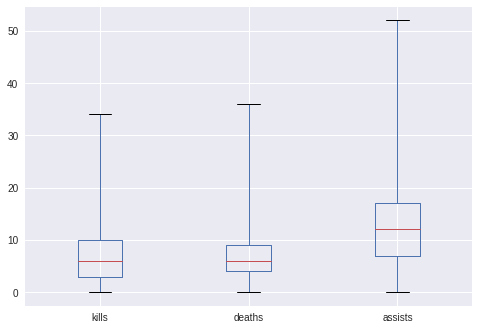

In [0]:
matches.boxplot(column=['kills','deaths','assists'], whis='range')

###Контрольні питання

<pre>**1. Що таке вибірка? Яку вибірку можна назвати репрезентативною ?**
    **Вибірка** - це множина об'єктів, подій, зразків або сукупність вимірів, за допомогою визначеної процедури вибраних з генеральної сукупності(ГС) для участі в дослідженні.
    **Репрезентативна вибірка** - вибірка, що відображає властивості ГС.

**2. В чому ключова відмінність між стратифікованою та груповою виборками?**
    Ідея **стратифікованої вибірки** в розбитті ГС на декілька відмінних груп і застосування методу **простої випадкової вибірки**(ППВ), тобто взяти представників ГС абсолютно випадковим чином. **Групова вибірка** це та ж сама стратифікована вибірка, але представники ГС повинні бути схожими між собою.

**3. В чому полягає критичний недолік розмаху? І чому на вашу думку це є саме критичним недоліком?**
    Основна проблему в тому , що він використовує лише 2 крайніх значення, що можуть сильно відрізнятися він більшості значень. І будь-які зміни цих значень будуть вкрай відчутно відображатись на результаті.

**4. В чому полягає різниця між дисперсією та середнім квадратичним відхиленням?**
    **Дисперсія** - це середній квадрат відхилень індивідуальних значень показника від його середнього значення. А **середнє квадратичне відхилення ** відображає наскільки в середньому кожен елемент нашої вибірки відхиляється від середнього значення по даній вибірці.

**5. За що відповідають квантилі розподілу? Яким чином їх можна найкраще представити?**
    **Квартилі розподілу** - це 3 точки, які ділять впорядковану множину даних на чотири рівних частини.

**6. Що таке міжквартильний розмах ?**
     Різниця між верхньою і нижньою межею. Чим більше значення має цей розмах - тим більша варіативність показника.

**7. Коли дедлайн здачі лаб №1 і що в неї входить? 😅**

https://uk.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D0%9F%D0%B0%D1%80%D0%BA%D1%96%D0%BD%D1%81%D0%BE%D0%BD%D0%B0

##Частина 3

###z-стандартизація

In [0]:
cols = ['kills', 'deaths','assists']
for col in cols:
    col_zscore = col + '_zsc'
    matches[col_zscore] = (matches[col] - matches[col].mean())/matches[col].std(ddof=0)
matches.head()

,assists,deaths,duration,kills,match_id,party_size,start_time,attack_type,legs,hero_name,primary_attr,roles,KDA,faction,win,duration_sec,kills_zsc,deaths_zsc,assists_zsc
0,0,1,00:06:12,0,333991287,0,2013-10-05 12:14:41,Melee,2.0,Treant Protector,str,"[Support, Initiator, Durable, Disabler, Escape]",0.000000,dire,True,372,-1.350129,-1.458877,-1.737771
1,0,13,00:38:35,1,334011324,0,2013-10-05 12:30:01,Ranged,2.0,Rubick,int,"[Support, Disabler, Nuker]",0.076923,radiant,False,2315,-1.155221,1.630702,-1.737771
2,0,0,00:18:02,1,401678802,0,2013-11-27 16:22:40,Ranged,2.0,Vengeful Spirit,agi,"[Support, Initiator, Disabler, Nuker, Escape]",1.000000,radiant,False,1082,-1.155221,-1.716342,-1.737771
3,4,6,00:34:22,0,401833965,0,2013-11-27 18:50:08,Ranged,0.0,Venomancer,agi,"[Support, Nuker, Initiator, Pusher, Disabler]",0.666667,radiant,False,2062,-1.350129,-0.171552,-1.181317
4,22,7,00:43:15,20,402632792,0,2013-11-28 14:24:30,Ranged,2.0,Crystal Maiden,int,"[Support, Disabler, Nuker, Jungler]",6.000000,dire,True,2595,2.548034,0.085912,1.322727


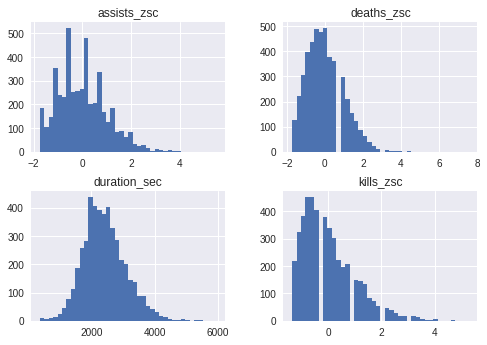

In [0]:
hist = matches.hist(column=['kills_zsc','deaths_zsc', 'assists_zsc','duration_sec'], bins=40) 

####Правило 2х-3х Сігм


In [0]:
def getSigmaRule(col, num):
  exp_ratio = None
  if num == 1:
    exp_ratio = 0.68
  elif num == 2:
    exp_ratio = 0.95
  elif num == 3:
    exp_ratio = 0.997
  else:
    return print('invalid data')
  
  lower_bound = matches[col].mean()-matches[col].std()*num
  uppper_bound = matches[col].mean()+matches[col].std()*num
  
  valid = matches[(matches[col] > lower_bound)&(matches[col] < uppper_bound)]
  ratio = len(valid.index)/len(matches.index)
  print('We expected '+str(exp_ratio)+' ratio and got this one: ' + str(ratio))
  
getSigmaRule('kills', 1)
getSigmaRule('duration_sec', 2)
getSigmaRule('deaths', 3)

We expected 0.68 ratio and got this one: 0.7384680490901396
We expected 0.95 ratio and got this one: 0.9545069826491748
We expected 0.997 ratio and got this one: 0.994710114261532


###Довірчі інтвервали для середнього значення (ДІ)



In [0]:
import math

def get_CI(col, percentage):
  if percentage == (95 or 0.95) :
    coef = 1.98
  elif percentage == (99 or 0.99):
    coef = 2.58
  else:
    return print('invalid data')
  se = matches[col].std()/math.sqrt(len(matches[col].index))
  CI_lower = matches[col].mean() - se*coef
  CI_upper = matches[col].mean() + se*coef
  print (str(percentage)+ '% confidence interval for '+col +' is '+ str(CI_lower) + ' - ' + str(CI_upper) )
  
  
get_CI('kills', 95)
get_CI('assists', 99)




95% confidence interval for kills is 6.7792132434265024 - 7.07478591019178
99% confidence interval for assists is 12.221943162518217 - 12.761552393977764


###Контрольні питання

**1. Що ви знаєте про нормальний розподіл? Які його характеристики?**
    <br>
  **Нормальний розподіл** — розподіл ймовірностей випадкової величини, що характеризується густиною ймовірності:</pre>

   >>>>>>$\ \LARGE f(x|\mu, \sigma) = \dfrac{1}{\sigma \sqrt{2\pi}} e^{-\dfrac{(x-\mu)^2}{2 \sigma^2}}$
 *де **μ** — математичне сподівання, **σ** — стандартне відхилення.*
Розподіл із **μ = 0** та **σ^2 = 1** називають стандартним нормальним розподілом.

**2. Що таке z-стандартизація? Навіщо вона потрібна? В чому вона вимірюється? І що, скажімо, означає, якщо z-значення = 1.5?**
     <br>**z-стандартизація** - перетворення отриманих даних, у стандартну **Z-шкалу** із такими характеристиками:</pre>
- середнє значення $\ M_z$ відтепер буде = 0;
- дисперсія і стандартне відхилення $\ D_z$ = 1.

**3. Для чого потрібна гістограма?**

Для кількісних досліджень.

**4. В чому суть правила 2-3 Сігм?**
 <br>Можна дізнатися де будуть знаходитися 68%, 95%, та 100% спостережень за середнім арифметичним значенням та середнє квадратичне відхиленням

**5. В чому основна суть ЦГТ?**

Наприклад, отримано вибірку, яка містить велику кількість спостережень, кожне з яких було отримано випадковим чином і вони не залежать від інших спостережень, і на основі значень цих спостережень розраховують арифметичне середнє. Якщо цю процедуру повторити багато разів, центральна гранична теорема стверджує, що розраховані середні значення будуть мати нормальний розподіл.

**6. В чому можуть допомогти довірчі інтервали для середнього? Яке їх призначення?**

Наприклад, результати опитування показали, що кандидат набере на виборах 40 % голосів. Проте математично правильніше сказати: з імовірністю 90 % кількість голосів набраних кандидатом згідно з опитуваннями лежить в інтервалі 40±3 %. Тут довірчим інтервалом є ±3 %.

**7. Наскільки необхідно змінити межу нашого довірчого інтервалу, щоб збільшити ймовірність включення середнього з генеральної сукупності у нього з 95% до 99%?**

На ± 0.6*se


#2. Опрацювання можливостей по візуалізації через дані

##Приклади

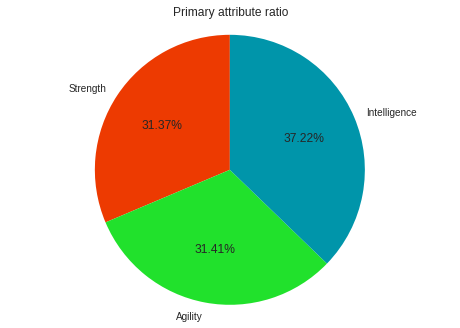

In [0]:
#      #1

import matplotlib.pyplot as plt

labels = 'Strength', 'Agility', 'Intelligence'
sections = [len(matches[matches.primary_attr == 'str'].index),
            len(matches[matches.primary_attr == 'agi'].index),
            len(matches[matches.primary_attr == 'int'].index)]
colors = ['#ed3a01', '#21e12c', '#0095aa']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        autopct = '%1.2f%%')

plt.axis('equal')
plt.title('Primary attribute ratio')
plt.show()

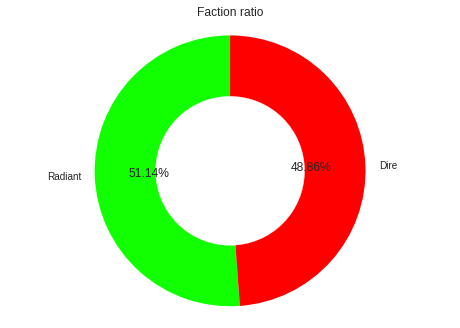

In [0]:
#      #2

labels = 'Radiant', 'Dire'
sections = [len(matches[matches.faction == 'radiant'].index),
            len(matches[matches.faction == 'dire'].index)]
colors = ['#11ff00', '#ff0000']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        autopct = '%1.2f%%')

plt.axis('equal')
plt.title('Faction ratio')

my_circle=plt.Circle( (0,0), 0.55, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


plt.show()

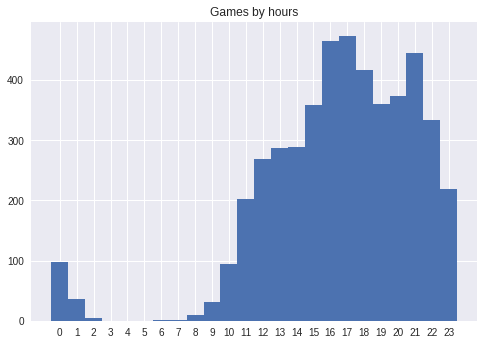

In [0]:
#      #3

import numpy as np

h = matches.start_time + datetime.timedelta(hours = 2) # +2 години, щоб отримати київський час
plt.hist(h.dt.hour , bins=24, range = (0,24))
plt.title("Games by hours")
plt.xticks(np.arange(0, 24, step=1)+0.5, range(0,24))
plt.show()

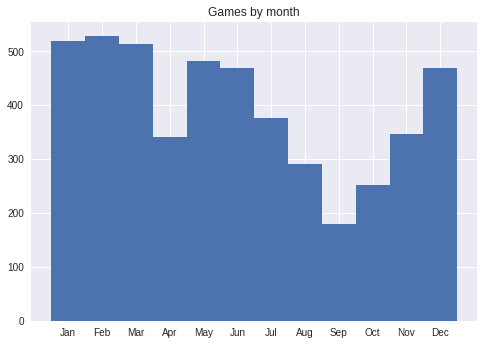

(array([519., 528., 514., 340., 482., 469., 376., 291., 180., 252., 347.,
        469.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 12 Patch objects>)

In [0]:
#      #4

import calendar 
a = matches.start_time + datetime.timedelta(hours = 2)
h = plt.hist(a.dt.month , bins=range(1,14))
plt.title("Games by month")

plt.xticks(np.arange(1, 13, step=1)+0.5,calendar.month_abbr[1:13])

plt.show()
h


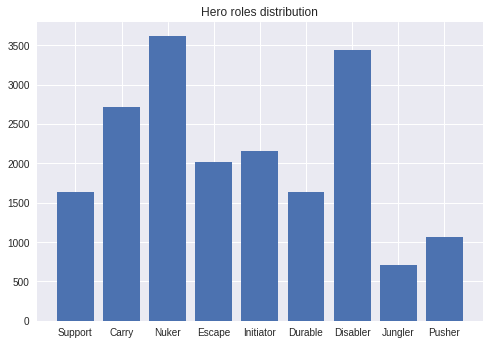

In [0]:
#      #5

import numpy as np
import matplotlib.pyplot as plt
 
bars = ('Support', 'Carry', 'Nuker', 'Escape', 'Initiator','Durable','Disabler','Jungler','Pusher')

roles = [0]*9
for role in matches.roles:
  if not isinstance(role,list):
    continue
  if 'Support' in role:
    roles[0] +=1
  if 'Carry' in role:
    roles[1] +=1
  if 'Nuker' in role:
    roles[2] +=1
  if 'Escape' in role:
    roles[3] +=1
  if 'Initiator' in role:
    roles[4] +=1
  if 'Durable' in role:
    roles[5] +=1
  if 'Disabler' in role:
    roles[6] +=1
  if 'Jungler' in role:
    roles[7] +=1
  if 'Pusher' in role:
    roles[8] +=1
    
y_pos = np.arange(len(bars))
plt.bar(y_pos, roles)
 
plt.xticks(y_pos, bars)
plt.title("Hero roles distribution")

plt.show()


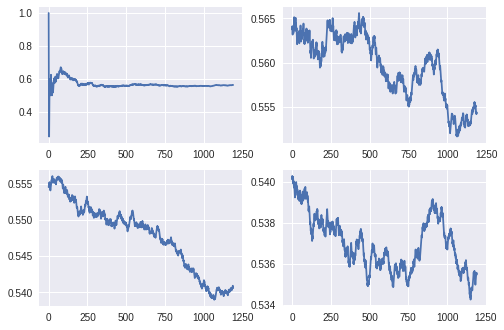

In [0]:
#      #6

wins, losses = 0,0
winrates = [None]*len(matches.index)
for i in range(0,len(matches.index)):
  if matches.win[i]:
    wins+=1
  else:
    losses +=1
  winrates[i] = wins/(losses+wins) 
  
  
plt.subplot(221)
plt.plot(winrates[0:len(winrates)//4-1])
plt.subplot(222)
plt.plot(winrates[len(winrates)//4:2*(len(winrates)//4)-1])
plt.subplot(223)
plt.plot(winrates[2*len(winrates)//4:3*(len(winrates)//4)-1])
plt.subplot(224)
plt.plot(winrates[3*len(winrates)//4:])

plt.show()
  


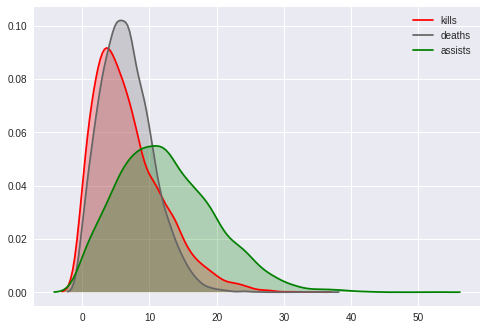

In [0]:
#      #7

import seaborn as sns 

sns.kdeplot(matches.kills, shade=True, color = 'r')
sns.kdeplot(matches.deaths, shade=True, color = '#666666')
sns.kdeplot(matches.assists, shade=True, color = 'g')

sns.plt.show()


In [0]:
!pip install WordCloud

    100% |████████████████████████████████| 368kB 5.5MB/s 


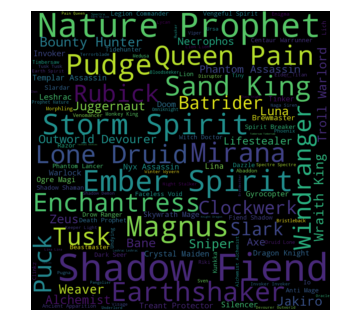

In [0]:
#      #8

from wordcloud import WordCloud

text =""
for hero in matches.hero_name:
  if not isinstance(hero,str):
    continue
  text += hero + " "

wordcloud = WordCloud(width=900, height=900, margin=0).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

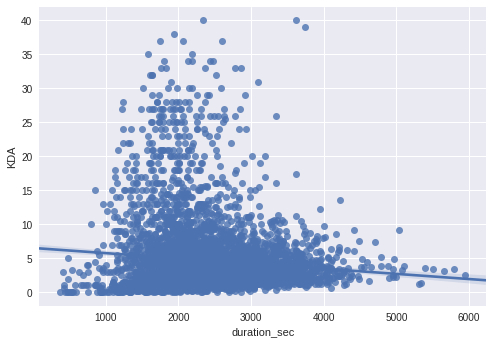

In [0]:
#      #9 

sns.regplot(x=matches["duration_sec"], y=matches["KDA"])
sns.plt.show()


In [0]:
!pip install matplotlib_venn

    100% |████████████████████████████████| 40kB 2.0MB/s 
  Running setup.py bdist_wheel for matplotlib-venn ... - done
  Stored in directory: /root/.cache/pip/wheels/d8/88/2f/e41518cb16e58109e8d14dc5dd7ef8166c82dce86c7c6d6c80
Successfully built matplotlib-venn


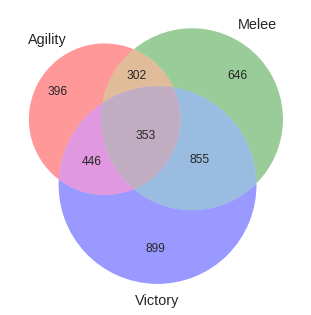

In [0]:
#      #10

from matplotlib_venn import venn3

venn3(subsets = (
    len(matches[(matches.primary_attr == 'agi')&
                (matches.attack_type != 'Melee')&
                (matches.win == False)
               ].index),
    len(matches[(matches.primary_attr != 'agi')&
                (matches.attack_type == 'Melee')&
                (matches.win==False)
               ].index),
    len(matches[(matches.primary_attr == 'agi')&
                (matches.attack_type == 'Melee') &            
                (matches.win == False)
               ].index),
    len(matches[(matches.primary_attr != 'agi')&
                (matches.attack_type != 'Melee') &            
                (matches.win)
               ].index),
    len(matches[(matches.primary_attr == 'agi')&
                (matches.attack_type != 'Melee') &            
                (matches.win)
               ].index),
    len(matches[(matches.primary_attr != 'agi')&
                (matches.attack_type == 'Melee') &            
                (matches.win)
               ].index),
    len(matches[(matches.primary_attr == 'agi')&
                (matches.attack_type == 'Melee') &            
                (matches.win)
               ].index),
    ),set_labels = ('Agility', 'Melee', 'Victory'))
plt.show()


##Контрольні питання

1. Ваші враження від такого феєричного ореолу засобів візуалізації в Python-екосистемі.

Прикольно робити непрості речі доволі простими шляхами.

2. Чим, на вашу думку, ще можна підсилити свої можливості по візуалізації, привнісши інструменти, що знаходяться ПОЗА межею Python-екосистеми?

Єдине, про що я чув - D3.js

#3. Порівняння середніх

## T-розподіл (Стьюдента)


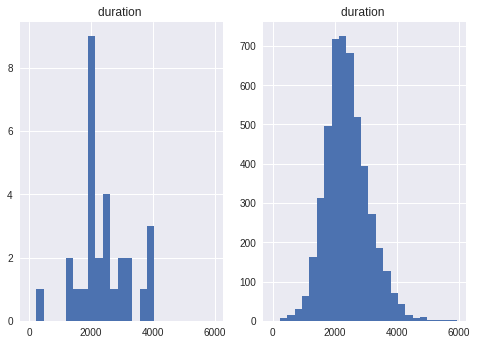

In [0]:
import matplotlib.pyplot as plt
import numpy as np

microsample = matches.sample(29)

plt.subplot(121);
plt.hist(microsample.duration_sec , bins=25, range = (0,matches.duration_sec.max()))
plt.title("duration ")

plt.subplot(122);
plt.hist(matches.duration_sec , bins=25, range = (0,matches.duration_sec.max()))
plt.title("duration ")

plt.show()

## Порівняння 2х середніх; t-критерій Стьюдента

Ttest_indResult(statistic=0.252293119405206, pvalue=0.8008404561872784)


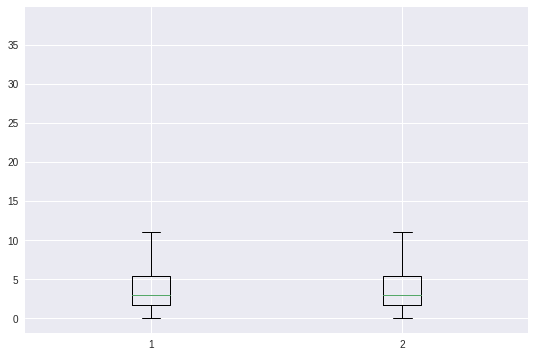

In [0]:
import math
from scipy import stats

sample_1 = matches[matches.faction == 'dire'].sample(1000)
sample_2 = matches[matches.faction == 'radiant'].sample(1000)

fig = plt.figure(1, figsize=(9, 6))

ax = fig.add_subplot(111)
bp = ax.boxplot([sample_1.KDA,sample_2.KDA])

print(stats.ttest_ind(sample_1.KDA,sample_2.KDA))

# p>0.05, отже ми не знайшли статично значимих відмінностей у значенні KDA за radiant і dire.

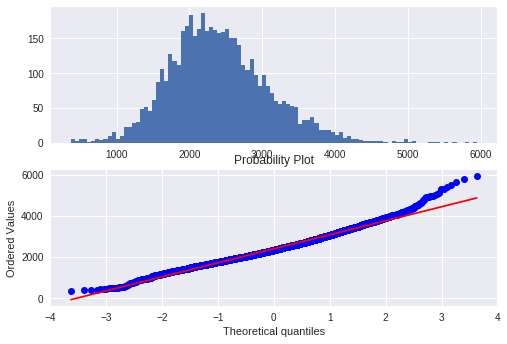

In [0]:
from scipy import stats
import numpy as np
from scipy.stats import norm

p1 = plt.subplot(211)
plt.hist(matches.duration_sec,bins = 100)
p2 = plt.subplot(212)
res = stats.probplot(matches.duration_sec, plot=plt)
plt.show()


##Однофакторний дисперсійний аналіз (ОДА) (ANOVA)



In [0]:
samples=[list(frame) for group,frame in matches.groupby('faction')['duration_sec']]
stats.f_oneway(*samples)

F_onewayResult(statistic=0.4599702656907934, pvalue=0.4976701389727729)

##Контрольні запитання

Опишіть своїми словами на прикладі свого датасету процес порівняння 2х середніх, мету його застосування та технології/тулзи/засоби, які при цьому використовуються.
________________________________________________________________



#4. Кореляція та регресія

##Кореляція

In [0]:
import pandas as pd 
from scipy import stats

pearson_coef, p_value = stats.pearsonr(matches.KDA, matches.duration_sec)
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value) 

# обернена кореляція (чим більша тривалість матчу, тим менше KDA)
#  p < 0.05, нульову гіпотезу можна спростувати, тобто зв'язок між KDA ы тривалістю існує

Pearson Correlation Coefficient:  -0.09615850776735871 and a P-value of: 1.806454603408588e-11


##Регресія

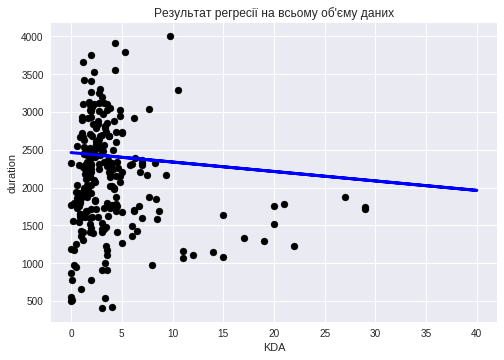

In [0]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

matches.KDA.fillna(0, inplace=True)
matches.duration_sec.fillna(0, inplace=True)
x = matches.KDA.values
y = matches.duration_sec.values
X = x.reshape(matches.KDA.shape[0], 1)
Y = y.reshape(matches.duration_sec.shape[0], 1)

X_train = X[:-250]
X_test = X[-250:]
 
Y_train = Y[:-250]
Y_test = Y[-250:]

regr = linear_model.LinearRegression()
regr.fit(X, Y) 

plt.title('Результат регресії на всьому об\'єму даних')
plt.xlabel('KDA')
plt.ylabel('duration')

plt.scatter(X_test, Y_test,  color='black')
plt.plot(X, regr.predict(X), color='blue', linewidth=3)
plt.show()

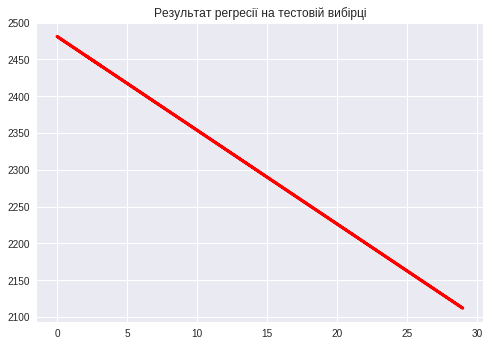

In [0]:
# Create linear regression object
regr = linear_model.LinearRegression()
 
# Train the model using the training sets
regr.fit(X_train, Y_train)
 
# Plot outputs
plt.title('Результат регресії на тестовій вибірці')
plt.plot(X_test, regr.predict(X_test), color='red',linewidth=3)

##Контрольні запитання

Опишіть заради якої мети використовують кореляцію та регресію. Які сильні сторони цих інструментів? Які "підводні камені"?


Кореляція може вказувати на відношення, яке може носити передбачуваний характер і тому мати практичне застосування.

Коефіцієнт кореляції Пірсона оцінює величину лінійної залежності двох величин, 